# Paper Implementation
[https://hal.science/hal-01428428v2]

Authors: Caio Hosken, Guilherme Railbolt

----------------------------------------------------------------------------

### Task -> texture inpainting using efficient gaussian conditional simulation

1. First idea is that any stationary gaussian random field can be computed as the convolution of gaussian noise with a kernel.

2. We already have the texture and the gaussian noise, so we need to compute the kernel.

3. to compute the kernel - tv(x) - is just follow the image below

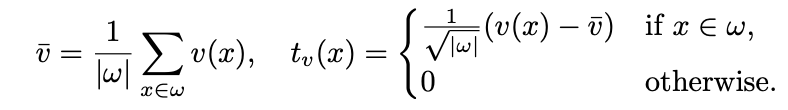

4. But as we are trying to solve a inpainting problem, we need a sample that make sense to the edges of the inpainting mask, that's why we use kriging

5. We choose some pixels of the mask edge to be the conditioning mask and use it to estimate the missing pixels. This estimator is the kriging component.

6. Generate a random gaussian noise that is the innovation component.

7. Add both computed components and add it into the inpainintg mask.

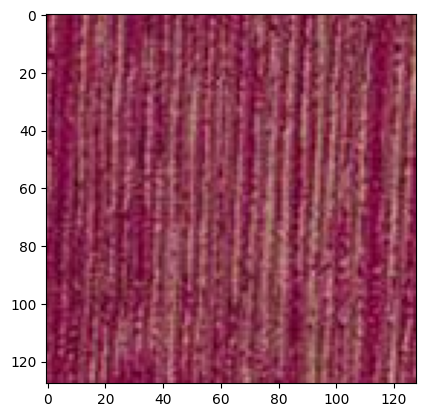

In [410]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('data/discharge_print_128x128.png')

# cv2 opens in BGR format for some reason
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image_rgb)

### RGB -> Greyscale

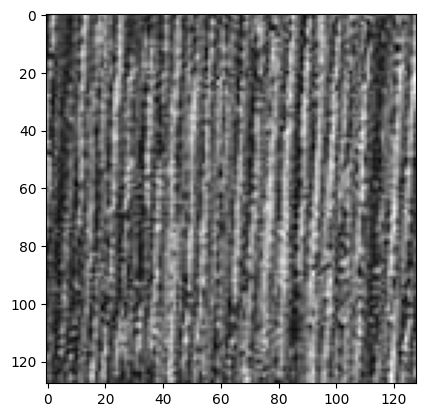

In [411]:
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
image_gray = image_gray.astype(np.float32)
height, weight = image_gray.shape
plt.imshow(image_gray,cmap="gray")

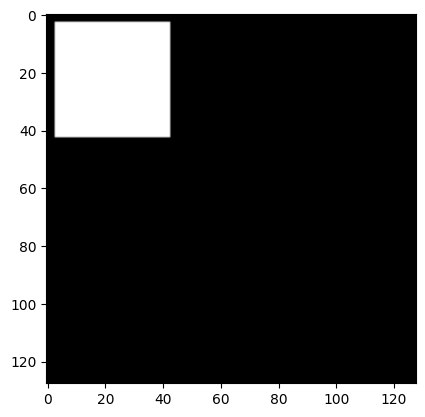

In [412]:
def createMask(img_shape,mask_size, mask_center):
    mask = np.zeros(img_shape, dtype=bool)

    mask_size = int(mask_size/2)
    row_start = max(mask_center[0] - mask_size, 0)
    row_end   = min(mask_center[0] + mask_size, img_shape[0])
    col_start = max(mask_center[1] - mask_size, 0)
    col_end   = min(mask_center[1] + mask_size, img_shape[1])

    mask[row_start:row_end,col_start:col_end]=True
    return mask



mask = createMask(image_gray.shape, mask_size=40, mask_center=np.array([23,23]))
plt.imshow(mask, cmap="gray")





In [413]:
image_gray.size

16384

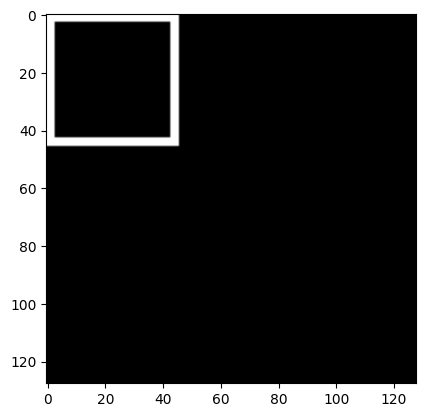

In [414]:
def createCondMask(img_shape,mask_size, mask_center, depth=3):

    mask = createMask(img_shape,mask_size,mask_center,)
    mask_var = createMask(img_shape,mask_size+(depth*2),mask_center)

    mask_cond = mask_var.astype(int) - mask.astype(int)
    mask_cond = mask_cond.astype(bool)
    return mask_cond


mask_cond = createCondMask(image_gray.shape,mask_size=40, mask_center=np.array([23,23]))
plt.imshow(mask_cond, cmap="gray")

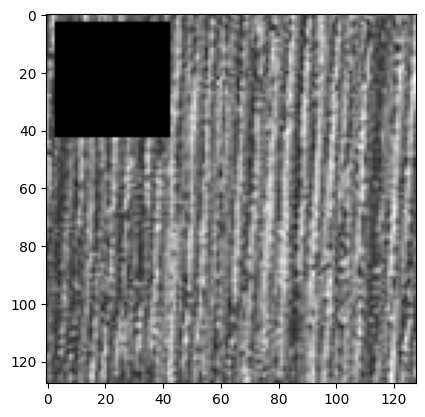

In [415]:
masked_img_gray = np.where(mask, 0, image_gray)
plt.imshow(masked_img_gray, cmap="gray")

In [416]:
texture_mean = masked_img_gray.mean(where=~mask)
count = masked_img_gray[~mask].size
print("Texture mean =",texture_mean)
print("number of pixels =",count)




Texture mean = 84.32765
number of pixels = 14784


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


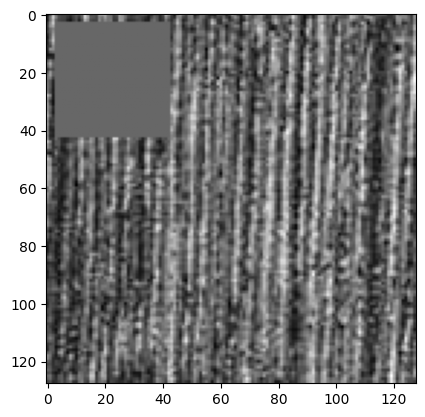

In [417]:
print(mask)
t = (image_gray - texture_mean)/((count)** (1/2))
t1 = (image_gray - texture_mean)

spot=np.where(mask, 0, t)
plt.imshow(spot, cmap="gray")

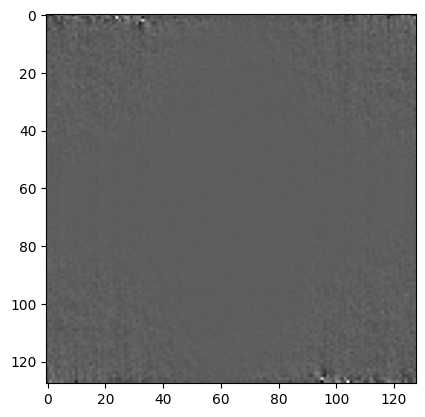

In [436]:
fft_spot = np.fft.fft2(spot)
plt.imshow(fft_spot.real, cmap="gray")

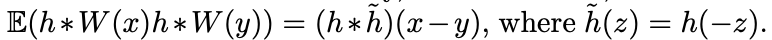

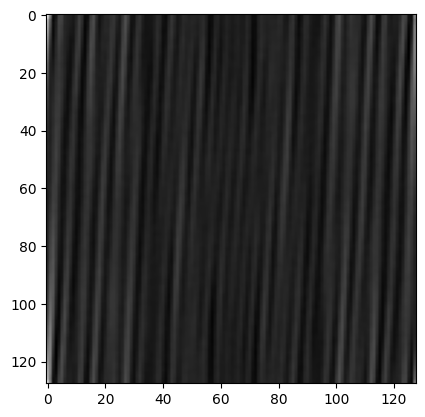

In [434]:
cov = np.fft.ifft2(np.abs(fft_spot) ** 2).real
plt.imshow(cov, cmap="gray")

In [420]:
cov.shape

(128, 128)

In [421]:
# Create the A matrix with the desired size and take the conditioning points

pixels_c_coords = np.argwhere(mask_cond)
N = len(pixels_c_coords)

A = np.zeros((N, N))


# We need to shift from the left-up side to the center using fftshift
cov_shifted = np.fft.fftshift(cov)
height, width = cov.shape

# The cv matrix is built in function of h, not (i,j). So we need to calculate each h and then take the right pixel
for i in range(N):
    for j in range(N):
        y_i, x_i = pixels_c_coords[i]
        y_j, x_j = pixels_c_coords[j]
        
        
        delta_y = y_j - y_i
        delta_x = x_j - x_i
        
        valor_cov = cov_shifted[height // 2 + delta_y, width // 2 + delta_x]
        A[i, j] = valor_cov

Sample the gaussian model!

In [422]:
A

array([[ 6.33124695e+02,  2.89859680e+02, -6.94574356e+01, ...,
        -1.18060875e+01,  2.43661880e-01, -7.10919666e+00],
       [ 2.89859680e+02,  6.33124695e+02,  2.89859680e+02, ...,
        -1.29246864e+01, -1.18060875e+01,  2.43661880e-01],
       [-6.94574356e+01,  2.89859680e+02,  6.33124695e+02, ...,
         1.40623932e+01, -1.29246864e+01, -1.18060875e+01],
       ...,
       [-1.18060856e+01, -1.29246902e+01,  1.40623894e+01, ...,
         6.33124695e+02,  2.89859680e+02, -6.94574356e+01],
       [ 2.43663788e-01, -1.18060856e+01, -1.29246902e+01, ...,
         2.89859680e+02,  6.33124695e+02,  2.89859680e+02],
       [-7.10919714e+00,  2.43663788e-01, -1.18060856e+01, ...,
        -6.94574356e+01,  2.89859680e+02,  6.33124695e+02]],
      shape=(516, 516))

In [423]:
texture_mean

np.float32(84.32765)

In [424]:
masked_img_gray[~mask].shape

(14784,)

In [425]:
A.shape

(516, 516)

Next steps:


Calculate the kriging component (u-v)*:
<li>Solve the linear problem A * ψ₁ = b, b being the conditioning - texture_mean   (Question: np.linalg.solve solves this or do we have to explicitly take the pseudoinverse?)</li>
<li>Build the covariance matrix Γ_mc (influence of border C to the mask M)</li>
<li>Multiply ψ₁ by Γ_mc


instead of ffshift -> use |M|  and |N|



Calculate the inovation component (F-F)* using a gaussian noise


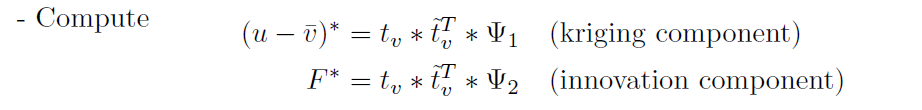

Generate the final matrix

In [426]:
## Solve the linear problem:
# A * ψ₁ = b

# b = (u - v-)*

cond_array = np.where(mask_cond,image_gray,0)

# Making it a vector
cond_array = cond_array.flatten()

# Removing the mask elements
cond_array = cond_array[cond_array != 0]

b = cond_array - texture_mean
kriging_w_1 = (np.linalg.pinv(A) @ b).real

kriging_w_1.shape

(516,)

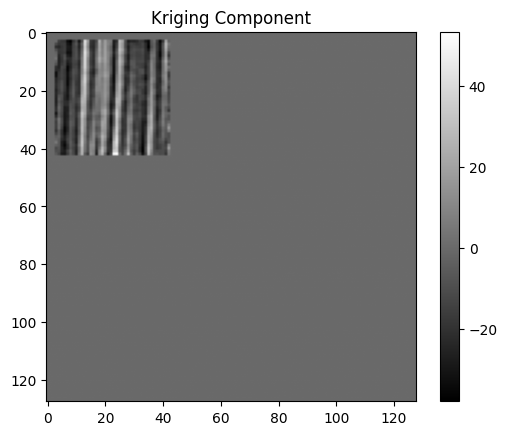

In [427]:
pixels_m_coords = np.argwhere(mask)
pixels_c_coords = np.argwhere(mask_cond)

P = len(pixels_m_coords)
N = len(pixels_c_coords)

Gamma_mc = np.zeros((P, N), dtype=np.float32)

cov_shifted = np.fft.fftshift(cov)
height, width = cov.shape

for i in range(P):
    for j in range(N):
        y_i, x_i = pixels_m_coords[i]
        y_j, x_j = pixels_c_coords[j]
        
        
        delta_y = y_i - y_j
        delta_x = x_i - x_j
        
        cov_value = cov_shifted[height // 2 + delta_y, width // 2 + delta_x]
        Gamma_mc[i, j] = cov_value.real

# (u - v)*_M = Γ_mc ⋅ ψ₁
kriging_component_M = Gamma_mc @ kriging_w_1.real

# Converting it back to a matrix
kriging_component_matrix = np.zeros_like(image_gray, dtype=np.float32)

for i in range(P):
    y, x = pixels_m_coords[i]
    kriging_component_matrix[y, x] = kriging_component_M[i]

plt.imshow(kriging_component_matrix, cmap='gray')
plt.title("Kriging Component")
plt.colorbar()
plt.show()

## Innovation component

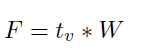

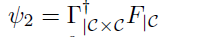

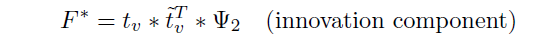

Extraído F_c com formato: (516,)


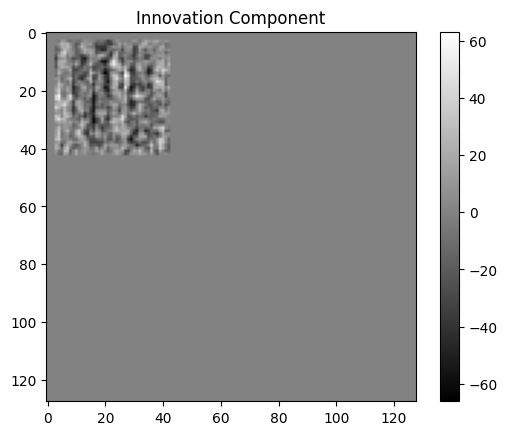

In [428]:
fft_spot = np.fft.fft2(spot)
W = np.random.randn(*image_gray.shape).astype(np.float32)
fft_W = np.fft.fft2(W)

# F = tᵥ * W
F = np.fft.ifft2(fft_spot * fft_W).real

F_c = F[mask_cond]
print(f"Extraído F_c com formato: {F_c.shape}")

# Solving the linear equation
kriging_w_2 = np.linalg.pinv(A) @ F_c

# F*
F_star_M = Gamma_mc @ kriging_w_2

# Getting only the F inside the mask
F_M = F[mask]

# F - F*
innovation_vector = F_M - F_star_M

innovation_component_matrix = np.zeros_like(image_gray, dtype=np.float32)

for i in range(P):
    y, x = pixels_m_coords[i]
    innovation_component_matrix[y, x] = innovation_vector[i]

plt.imshow(innovation_component_matrix, cmap='gray')
plt.title("Innovation Component")
plt.colorbar()
plt.show()

# Final image

mean + kriging + innovation


--- Resultados ---


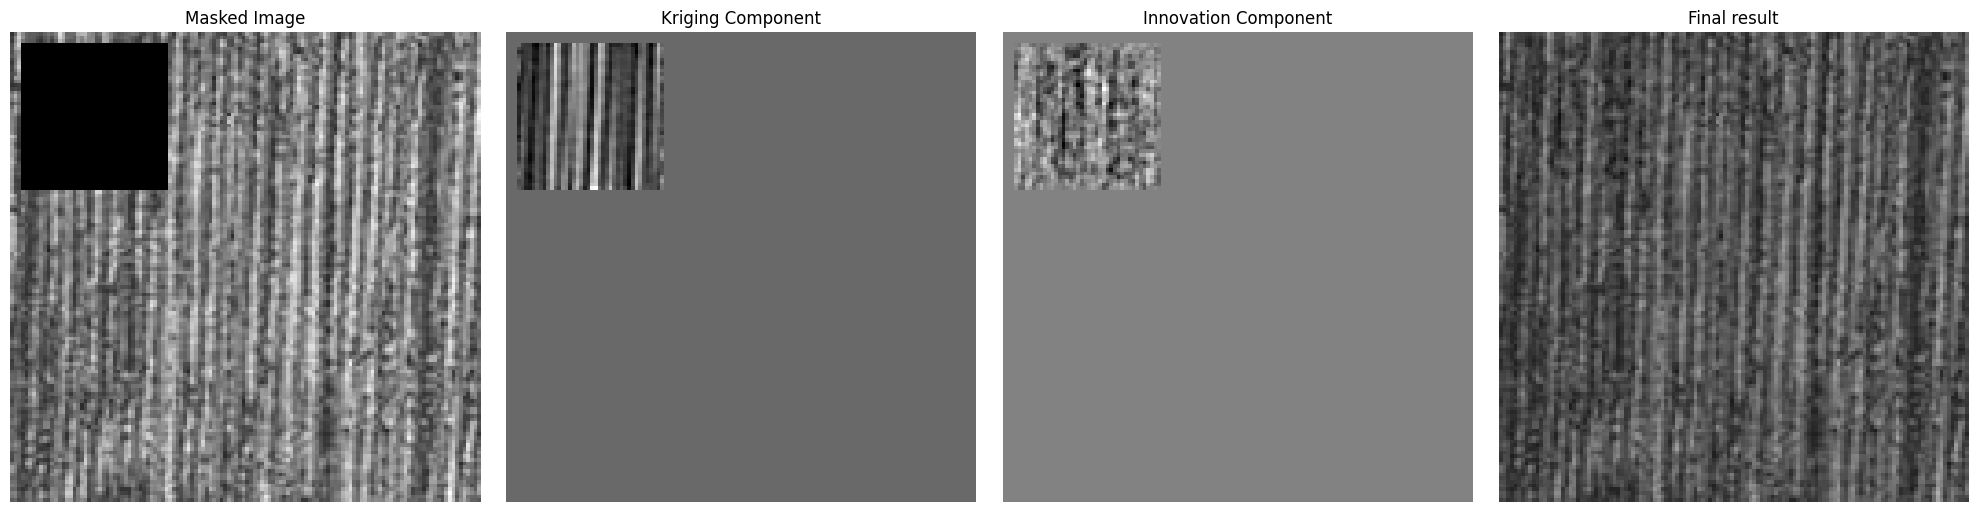

In [432]:
inpainted_region = texture_mean + kriging_component_matrix + innovation_component_matrix

final_image = np.where(mask, inpainted_region, image_gray)
final_image = np.clip(final_image, 0, 255).astype(np.uint8)

print("\n--- Resultados ---")

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(masked_img_gray, cmap='gray')
axes[0].set_title("Masked Image")

axes[1].imshow(kriging_component_matrix, cmap='gray')
axes[1].set_title("Kriging Component")

axes[2].imshow(innovation_component_matrix, cmap='gray')
axes[2].set_title("Innovation Component")

axes[3].imshow(final_image, cmap='gray', vmin=0, vmax=255)
axes[3].set_title("Final result")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# ---------------------------------------
## Terminar...

In [ ]:
tol = 10e-3
iteration=1000

solution_vector = np.zeros(cond_array.size)
At = A.transpose()
residual = ((At)@(cond_array))
direction = residual

In [ ]:
def apply_A_tA(A,vector):
    At = A.transpose()
    fft_A = np.fft.fft2(A)
    fft_At = np.fft.fft2(At)
    fft_v = np.fft.fft(vector)
    var = fft_v * fft_A * fft_At
    return np.fft.ifft2(var)

# E uma função para A @ v
def apply_A(A,vector):
    fft_A = np.fft.fft2(A)
    fft_v = np.fft.fft(vector)
    var = fft_A * fft_v
    return np.fft.ifft2(var)

def cgd():
    for it in range(iteration):
        old_residual = residual
        residual_norm = n|p.linalg.norm(residual)
        alfa = (residual_norm**2)/(direction.transpose() * A.transpose() * (A@direction))
        solution_vector = solution_vector + (alfa * direction)
        residual = residual - (alfa * A.transpose() * A * direction)
        direction = residual+((((np.linalg.norm(residual))**2)/(np.linalg.norm(old_residual)**2))* direction)
        if residual_norm < tol:
            break
    return solution_vector

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Recommended to convert to float32 do the mathematical expressions with more precision
im = image_rgb.astype(np.float32)

print(f"Image shape: {im.shape}")

plt.imshow(im.astype(np.uint8))
plt.title("Original Image")
plt.axis('off')
plt.show()

In [4]:
def generate_zero_padding_kernel(im, k):
    pad_width = k // 2

    if im.ndim == 3:
        m, n, c = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width, c), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width, :] = im
    elif im.ndim == 2:
        m, n = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width] = im
    else:
        raise ValueError("Image must have either 2 or 3 dimensions")

    return im_pad

def generate_zero_padding_fft(im):
    m, n, c = im.shape
    im_pad = np.zeros((2*m, 2*n, c))
    im_pad[:m, :n, :] = im
    print(im.shape, im_pad.shape)
    return im_pad

def generate_gausian_matrix(shape):
    gaus = np.random.randn(*shape)

    return gaus

# This returns a mean vector (one mean for each channel)
u = np.mean(im, axis=(0, 1))


tu = (im - u)/np.sqrt(im[:,:,0].size)

tu_pad = generate_zero_padding_fft(tu)

W = generate_gausian_matrix(tu_pad.shape)

tu_fft = np.fft.fft2(tu_pad, axes=(0, 1))
W_fft = np.fft.fft2(W, axes=(0, 1))

convolution = tu_fft * W_fft

im_convoluted = np.fft.ifft2(convolution, axes=(0, 1))

# Remove padding
im_convoluted_unpad = im_convoluted[0:im.shape[0], 0:im.shape[1]]

# Remember to get that ifft returns a complex number!
result = u + np.real(im_convoluted_unpad)

# The previous operations make it so that result has negative values, we need to clip them
final_result = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(final_result)

NameError: name 'np' is not defined

Problems:

- Generated three different gaussian noises, one for each color. Since they were randomized separately, this messed up the covariance between colors. To fix this i should have done one random and copy this to the other 2 channels -> Explained in the 3.1 section of the paper


- Maybe the convolution was wrong. I was not supposed to multiply the magnitude of the image and the gaussian noise's magnitude? Maybe preserve the magnitude from the original image and then just replace the phase by the gaussian's, proving that for textures that does not change anything.




Fix:
Generate three equal noises

Change the logic to:

U = v + F-1( |t_v|  /_ arg(W)+arg(W)  )

Basically we maintain the magnitude from our "bord" (the ohmega set) and randomize the phase, making it chaotic, as a microtexture should be.



OBS: Since im doing "manually", there will be no need to do the padding

In [5]:
def generate_zero_padding_kernel(im, k):
    pad_width = k // 2

    if im.ndim == 3:
        m, n, c = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width, c), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width, :] = im
    elif im.ndim == 2:
        m, n = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width] = im
    else:
        raise ValueError("Image must have either 2 or 3 dimensions")

    return im_pad

def generate_zero_padding_fft(im):
    m, n, c = im.shape
    im_pad = np.zeros((2*m, 2*n, c))
    im_pad[:m, :n, :] = im
    print(im.shape, im_pad.shape)
    return im_pad

def generate_gausian_matrix(shape):
    gaus = np.random.randn(*shape)

    return gaus

# This returns a mean vector (one mean for each channel)
u = np.mean(im, axis=(0, 1))


tu = (im - u)


single_channel_noise = np.array(generate_gausian_matrix(tu.shape[0:2]))

W = np.dstack([single_channel_noise, single_channel_noise, single_channel_noise])

tu_fft = np.fft.fft2(tu, axes=(0, 1))
tu_mag = np.abs(tu_fft)
tu_phase = np.angle(tu_fft)


W_fft = np.fft.fft2(W, axes=(0, 1))
W_mag = np.abs(W_fft)
W_phase = np.angle(W_fft)

# Assemble both
result = tu_mag * np.exp(1j * W_phase)

image_gaussian_noise = np.fft.ifft2(result, axes=(0, 1))


# Remember to get that ifft returns a complex number!
result = u + np.real(image_gaussian_noise)

# The previous operations make it so that result has negative values, we need to clip them
final_result = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(final_result)

NameError: name 'np' is not defined

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # Adicionar figsize é uma boa prática


ax[0].imshow(im.astype(np.uint8))
ax[0].set_title("Original Image")

ax[1].imshow(final_result)
ax[1].set_title("Synthesized Result")

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

TO DO: add the masks to see the results